In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X_train = train.drop('label', axis=1)
y_train = train['label']

In [5]:
X_train = X_train.values.reshape(-1, 28, 28).astype('float32') / 255.0
X_test = test.values.reshape(-1, 28, 28).astype('float32') / 255.0

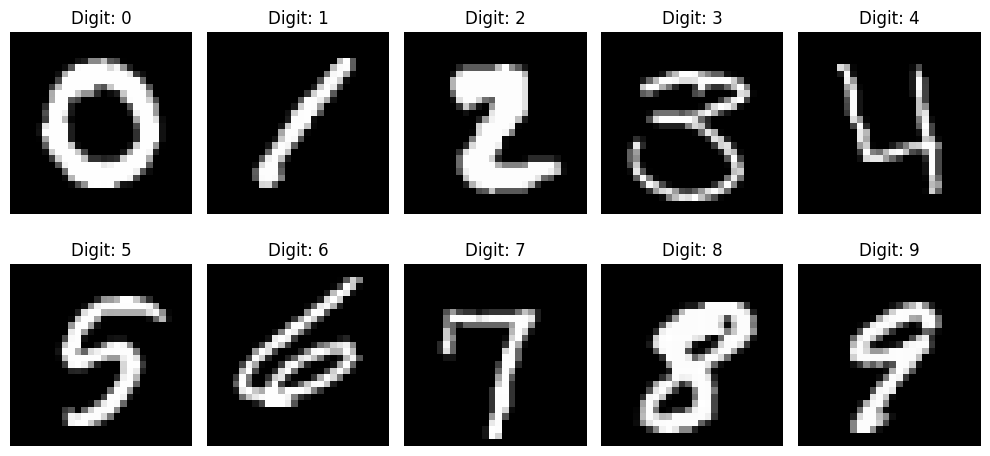

In [6]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[y_train == i][0], cmap='gray')
    plt.title(f'Digit: {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
class DigitData(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform 
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
            
        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.1307,), (0.3081,))
])

In [9]:
train_dataset = DigitData(X_train, y_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = DigitData(X_test, transform=transform) 
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

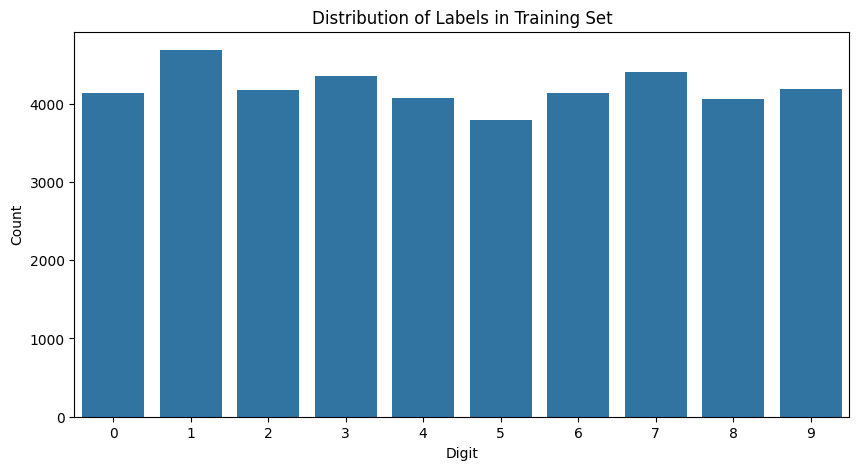

In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train)
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [13]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [15]:
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/20], Loss: 0.1620
Epoch [2/20], Loss: 0.0564
Epoch [3/20], Loss: 0.0404
Epoch [4/20], Loss: 0.0312
Epoch [5/20], Loss: 0.0242
Epoch [6/20], Loss: 0.0227
Epoch [7/20], Loss: 0.0171
Epoch [8/20], Loss: 0.0185
Epoch [9/20], Loss: 0.0144
Epoch [10/20], Loss: 0.0118
Epoch [11/20], Loss: 0.0128
Epoch [12/20], Loss: 0.0114
Epoch [13/20], Loss: 0.0114
Epoch [14/20], Loss: 0.0097
Epoch [15/20], Loss: 0.0093
Epoch [16/20], Loss: 0.0067
Epoch [17/20], Loss: 0.0081
Epoch [18/20], Loss: 0.0073
Epoch [19/20], Loss: 0.0062
Epoch [20/20], Loss: 0.0089


In [16]:
predictions = []
model.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

In [17]:
submission = pd.DataFrame({'ImageId': range(1, len(predictions) + 1), 'Label': predictions})
submission.to_csv('submission.csv', index=False)

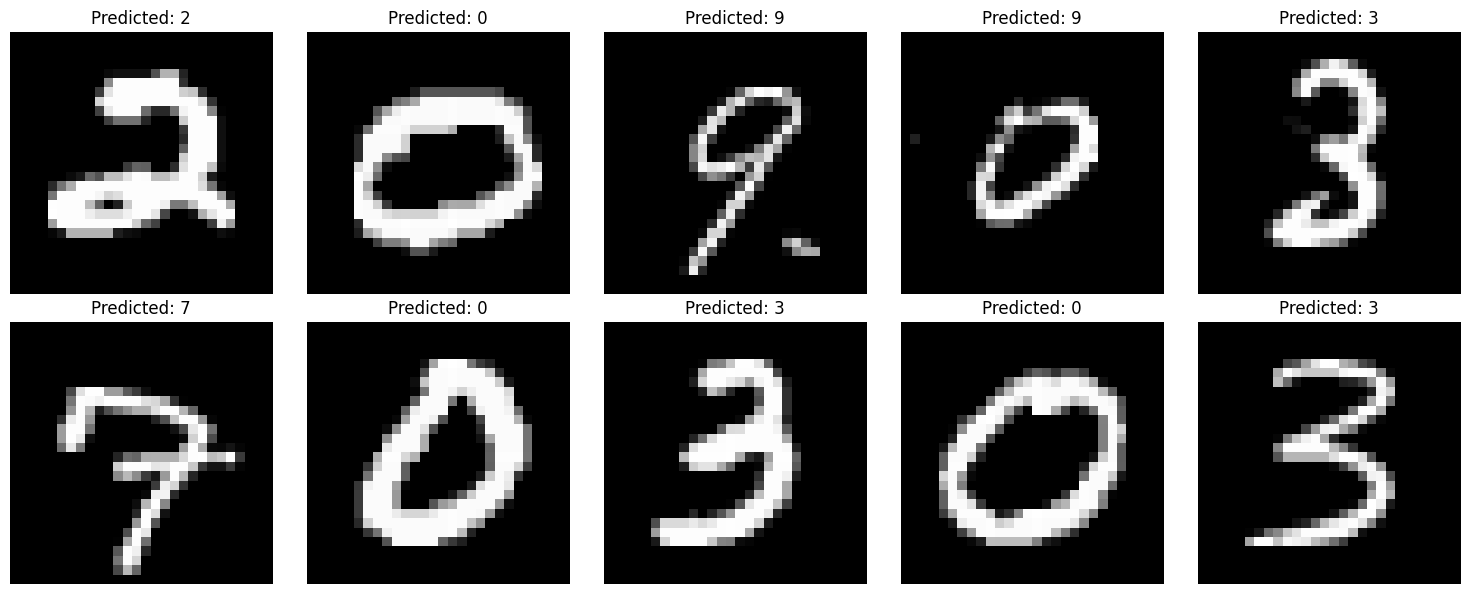

In [18]:
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i], cmap='gray')
    plt.title(f'Predicted: {predictions[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Kaggle score: 0.99007